<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/3.%20Frameworks%20Software/Practica3.4.%20Keras%3A%20clasificacion%20binaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 3.3. CLASIFICACIÓN BINARIA Y DATASETS DESBALANCEADOS

La clasificación binaria es, posiblemente, el tipo de problema con mayor número de aplicaciones en ML. En esta práctica vamos a ver cómo construir un clasificador binario en PyTorch, cómo trabajar con un dataset tabular y desbalanceado, y cómo trabajar con otras métricas de calidad. Concretamente, construiremos una red neuronal que nos ayude a clasificar si un movimiento en una tarjeta de crédito es fraudulento, mediante el dataset [*Credit Card Fraud Detection*](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

Comencemos importando PyTorch y comprobando si tenemos GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch version:', torch.__version__, '\nDevice:', device)

PyTorch version: 2.3.0+cu121 
Device: cuda


## 1. Preparación del dataset

### 1.1. Descarga

A continuación puedes descargar los datos y descomprimirlo con el siguiente código. Si el enlace de descarga ha dejado de funcionar, puedes descargarlo a mano desde [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud), o bien usando Kagglehub como se indica en la web.

In [2]:
from pathlib import Path
import requests
import zipfile

DATA_PATH = Path("./data")
PATH = DATA_PATH / "creditcard"

PATH.mkdir(parents=True, exist_ok=True)  # creamos la carpeta

URL = "https://clouda-labs-assets.s3-us-west-2.amazonaws.com/fraud-detection/"
FILENAME = "creditcard.csv.zip"

if not (PATH / FILENAME).exists(): # evitamos descargar si ya se ha descargado
        content = requests.get(URL + FILENAME).content  # descargamos el fichero
        (PATH / FILENAME).open("wb").write(content)

        with zipfile.ZipFile((PATH / FILENAME), 'r') as zip_ref: # descomprimimos el fichero
                zip_ref.extract("creditcard.csv", PATH)


Comprueba a continuación que puedes abrir correctamente el fichero con `Pandas` (si no tienes esta librería, te aconsejo instalarla con `pip install pandas`):

In [3]:
import pandas as pd

df = pd.read_csv(PATH / "creditcard.csv")
print("--- Primeras 5 filas del dataset ---")
df.head()

--- Primeras 5 filas del dataset ---


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.2. Exploración de los datos

El paso más importante a la hora de entrar cualquier modelo de machine learning, es entender el dataset y prepararlo adecuadamente para el modelo. Todo comienza por los datos, y por muy potente que sea un modelo, si los datos no tienen una buena calidad, conseguiremos resultados muy pobres.

A continuación podemos ver que efectivamente, el dataset está muy desbalanceado. Esto nos llevará a conseguir un modelo muy sesgado.


--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     28480

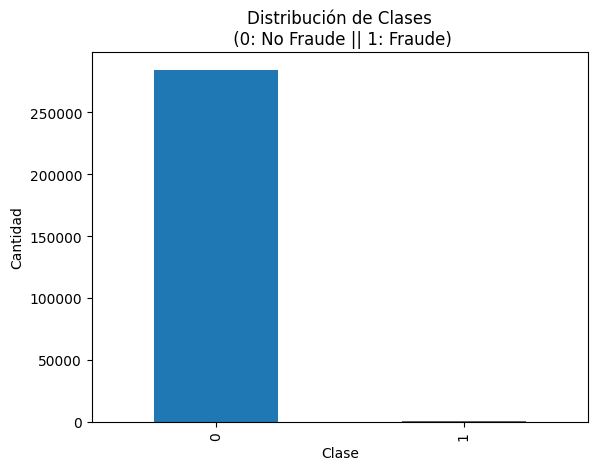


El dataset está muy desbalanceado: solo un 0.1727% de las transacciones son fraudulentas.


In [4]:
# Mostrar las primeras filas y la información general
print("\n--- Información del DataFrame ---")
df.info()

# --- Visualización del desbalance de clases ---
print("\n--- Distribución de Clases (Fraude vs. No Fraude) ---")
class_counts = df['Class'].value_counts()
print(class_counts)

# Gráfico para visualizar el desbalance
df['Class'].value_counts().plot(kind='bar')
plt.title('Distribución de Clases\n (0: No Fraude || 1: Fraude)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

# Imprimir el porcentaje de fraudes
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"\nEl dataset está muy desbalanceado: solo un {fraud_percentage:.4f}% de las transacciones son fraudulentas.")

### 1.3. Análisis y preparación de los datos

Antes de entrar a trabajar con los datos, hablemos antes sobre el preprocesamiento de datos tabulares (tablas) en Deep Learning. Esto es algo crítico y que tendrá un gran efecto sobre el entrenamiento de redes neuronales, y es que es esencial preparar los datos con dos transformaciones principales según el tipo de columna (variable):
1. **Codificación de variables categóricas (One-Hot Encoding)**: convierte una variables categórica (por ejemplo, color) en un formato numérico que el modelo pueda entender, creando una nueva variable *dummy* binaria (0 o 1) para cada categoría (por ejemplo, rojo, azul y verde). Por ejemplo, rojo se convierte en un vector [1, 0, 0], azul [0, 1, 0] y verde [0, 0, 1]. Esto evita que el modelo interprete las categorías como si tuvieran un orden o valor numérico, siendo "equidistantes" entre sí.

2. **Escalado de variables numéricas**: asegura que las variables con diferentes rangos y varianzas no dominen el entrenamiento. Esto previene que el modelo se vea sesgado por valores muy grandes o pequeños, mejorando su convergencia y rendimiento (por ejemplo, si en datos de viviendas, tenemos una variable con el tamaño en metros cuadrados y otra con el precio en euros). Hay dos métodos principales:  
  * **Normalización Min-Max (MinMaxScaler)**: Escala los datos para que se encuentren en un rango específico, generalmente [0, 1]. Útil cuando no conocemos la distribución de los datos, por ejemplo, en los valores de los píxeles de una imagen.
  * **Estandarización Z-Score (StandardScaler)**: Centra los datos a una media de 0 y una desviación estándar de 1. Es útil en algoritmos basados en gradiente o en reducción de dimensionalidad.

En nuestro caso, para proteger la privacidad de los usuarios y por cuestiones de confidencialidad, los creadores del dataset aplicaron una transformación matemática llamada *Análisis de Componentes Principales (PCA)* a los datos originales. Uno de los pasos estándar que se realizan antes de aplicar PCA es escalar los datos (por ejemplo, usando StandardScaler). Por lo tanto, las columnas `V` que recibimos en el dataset ya han sido transformadas y se encuentran en una escala comparable, centradas alrededor de cero. Puedes observar a continuación que las medias de estas variables son valores muy pequeños, cercanos al cero.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Sin embargo, las columnas `Amount` y `Time` son las originales, sin haber sido procesadas con PCA. Sus valores numéricos son tan grandes que dominarían el proceso de aprendizaje de la red neuronal. El modelo le daría muchísima más importancia a una variación en Amount (que puede ser de miles) que a una variación en V1 (que puede ser de 0.1), simplemente por la diferencia de magnitud. 

A continuación haremos uso de `StandardScaler`, una funcionalidad de `sklearn` (si no la tienes instalada, te aconsejo instalarla con `pip install scikit-learn`) en `Time` y `Amount`, las ponemos en la misma "escala" que las variables V. Esto asegura que el modelo pueda aprender de todas las características de manera justa, sin que ninguna domine a las demás por su magnitud numérica.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df[['scaled_Amount','Amount','scaled_Time','Time','V1','V2']].describe()

,scaled_Amount,Amount,scaled_Time,Time,V1,V2
count,2.848070e+05,284807.000000,2.848070e+05,284807.000000,2.848070e+05,2.848070e+05
mean,2.913952e-17,88.349619,-3.065637e-16,94813.859575,1.168375e-15,3.416908e-16
std,1.000002e+00,250.120109,1.000002e+00,47488.145955,1.958696e+00,1.651309e+00
min,-3.532294e-01,0.000000,-1.996583e+00,0.000000,-5.640751e+01,-7.271573e+01
25%,-3.308401e-01,5.600000,-8.552120e-01,54201.500000,-9.203734e-01,-5.985499e-01
50%,-2.652715e-01,22.000000,-2.131453e-01,84692.000000,1.810880e-02,6.548556e-02
75%,-4.471707e-02,77.165000,9.372174e-01,139320.500000,1.315642e+00,8.037239e-01
max,1.023622e+02,25691.160000,1.642058e+00,172792.000000,2.454930e+00,2.205773e+01


Por otro lado, podemos observar que las transacciones fraudulentas no tienden a suponer una gran cantidad de dinero (`Amount`), como se observa a continuación (observa la media y el máximo, y compáralo con la clase negativa):

--- Estadísticas de transacciones negativas (no fraufulentas) ---
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

--- Estadísticas de transacciones positivas (fraudulentas) ---
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb377399340>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb377399880>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fb3766b9f70>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb377399dc0>,
 'fliers': [],
 'means': []}

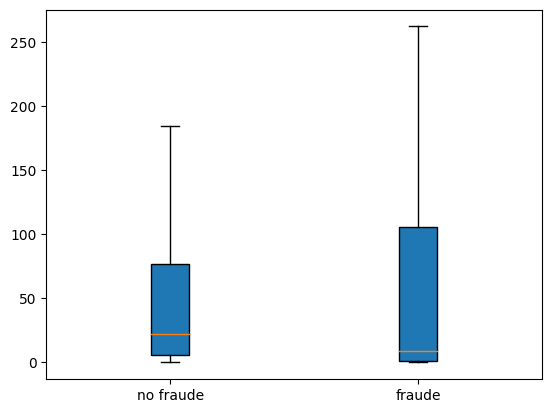

In [7]:
print("--- Estadísticas de transacciones negativas (no fraufulentas) ---")
print(df[df["Class"] == 0]["Amount"].describe())
print("\n--- Estadísticas de transacciones positivas (fraudulentas) ---")
print(df[df["Class"] == 1]["Amount"].describe())
plt.boxplot([df[df['Class']==0]['Amount'],df[df['Class']==1]['Amount']],
            patch_artist=True,labels=['no fraude','fraude'],
            showfliers=False)

In [8]:
# Eliminamos las columnas originales de 'Time' y 'Amount'
# Ya no nos hacen falta para entrenar el modelo
df.drop(['Time', 'Amount'], axis=1, inplace=True)

Para poder evaluar cómo va el progreso del entrenamiento, vamos a dividir el dataset en tres:
* _Conjunto de entrenamiento (train)_: con el que intentaremos optimizar los pesos de la red para que minimice la función de pérdida. 

* _Conjunto de validación (validation)_: con el que se medirá cómo de bueno es el modelo concreto que estamos entrenando (con unos parámetros fijos). Es algo así como un conjunto de test temporal. 

* _Conjunto de prueba (test)_: que no se ha usado en ningún momento de las iteraciones anteriores y que permite medir de forma objetiva la bondad del modelo final obtenido.

A continuación preparamos las características X y la etiqueta objetivo Y, y partimos el dataset en tres de forma estratificada. Esto es, ya que tenemos una gran desbalance, obligar a que tengamos una proporción igual de 0's y 1's tanto en train, validación como en test (si no, tendremos una gran probabilidad de tener en train solo ejemplos etiquetados como 0's).

In [9]:
from sklearn.model_selection import train_test_split

# Separamos características (X) y la etiqueta (y) 
X = df.drop('Class', axis=1)
y = df['Class']

# --- División Train-Valid-Test con ESTRATIFICACIÓN ---
# Haremos 60%, 20%, 20%   (se podría hacer otra repartición)
# Usamos stratify=y para asegurar que la proporción de clases se mantenga en ambos conjuntos.
# Esto es fundamental en datasets desbalanceados.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print("Forma de X_train: ", X_train.shape)
print("Forma de X_valid: ", X_valid.shape)
print("Forma de X_test: ", X_test.shape)

print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución de clases en el conjunto de validación:")
print(y_valid.value_counts(normalize=True))

print("\nDistribución de clases en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))

Forma de X_train:  (170883, 30)
Forma de X_valid:  (56962, 30)
Forma de X_test:  (56962, 30)

Distribución de clases en el conjunto de entrenamiento:
Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Distribución de clases en el conjunto de validación:
Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64

Distribución de clases en el conjunto de prueba:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


Ahora podemos crear los tensores. Observa que pasamos de un dataframe a un tensor pasando de forma intermedia a través de un numpy array (que se consigue con el método `values`). Después, creamos los Dataset y los DataLoaders correspondientes.

In [10]:
# Ya tenemos los datos particionados con scikit-learn
# Ahora necesitamos transformar los datos a Tensor
# Flujo: de dataframe --> numpy --> tensor
X_train = torch.FloatTensor(X_train.values)
X_test  = torch.FloatTensor(X_test.values)
X_valid = torch.FloatTensor(X_valid.values)
y_train = torch.FloatTensor(y_train.values)
y_valid = torch.FloatTensor(y_valid.values)
y_test  = torch.FloatTensor(y_test.values)

# --- Creamos el Dataset de train y de test ---
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_test)
test_ds  = TensorDataset(X_test, y_test)

In [11]:
# Veamos qué forma tienen ahora los datos
print(X_train.shape)
print(X_train[:3])
print(y_train.shape)
print(y_train[:3])

torch.Size([170883, 30])
tensor([[ 1.1178,  0.2562,  0.2427,  1.0938, -0.0309, -0.4564,  0.2715, -0.1672,
         -0.1893, -0.0810,  0.0126,  0.8481,  1.0620,  0.2132,  1.0588, -0.2885,
         -0.2077, -0.7241, -0.7504, -0.0181,  0.0939,  0.3064, -0.1207,  0.1182,
          0.6352, -0.3070,  0.0290,  0.0269, -0.1616, -0.8260],
        [-1.0475,  1.4038, -1.0241, -1.0990,  2.1321,  3.7278, -1.2693, -1.3488,
         -1.0964, -1.0854, -0.5517,  0.0869, -0.2439,  1.1204,  0.7177,  0.6170,
         -0.5492,  0.3859,  0.1628,  0.5744, -1.1410,  0.4663,  0.0911,  1.0171,
         -0.2585,  0.2850, -0.0537,  0.1186, -0.3472, -0.6119],
        [ 0.1610, -3.7500, -3.5407,  0.4242, -0.9017, -1.1548,  1.8575, -0.7402,
         -1.0276,  0.4950,  0.5841,  0.0152, -1.3410,  1.5088, -0.5715, -2.3493,
          0.1140,  1.6737, -0.7594,  1.3491,  0.6258,  0.0335, -1.0594,  0.0560,
          0.3031, -0.3205, -0.2341,  0.0931,  3.8564,  0.7914]])
torch.Size([170883])
tensor([0., 0., 0.])


In [12]:
# --- Creamos los DataLoaders ---
BATCH_SIZE = 1024
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False)

## 2. Definiendo la red

Después de un pre-procesamiento sencillo, nuestros datos de entrada son vectores (uno por cada ejemplo), y las etiquetas son escalares (1s y 0s), así que estamos ante la configuración más sencilla de las posibles para ser trabajadas con una red neuronal, y un tipo de red que funciona bien con este tipo de problemas es una simple pila de capas lineales con activaciones `ReLU`.

En general, en todo tipo de capas, los argumentos más habituales que tendrás que usar serán el número de neuronas en la capa, y el tipo de activación que usarán estas neuronas. En el caso anterior usamos 16 neuronas, lo que significa que esta capa usará 16 dimensiones para intentar estructurar los patrones que encuentre en los datos de entrada según la función objetivo (loss) que deba optimizar. 

Se puede interpretar intuitivamente que la dimensión de la capa representa cuánta libertad se permite a la red para aprender representaciones internas. Tener más unidades permite aprender representaciones más complejas, pero también aumenta la carga computacional y facilita la memorización de patrones en los datos de entrenamiento (que quizás no sean relevantes para el problema y que puede llevar al sobreajuste).

Respecto a la arquitectura al trabajar con capas densas, hay dos decisiones claves que considerar:

* Cuántas capas usar.
* Cuántas unidades colocar en cada capa.

Aunque no hay reglas generales para saber cómo tomar estas decisiones, sí que hay algunas razones que se pueden aprender con la experiencia y así poder extraer algún conocimiento implícito útil para el diseño de redes. Para este ejemplo, sin una justificación clara, y solo a modo de demostración de las técnicas vamos a usar la siguiente configuración:
* Una capa oculta con 32 neuronas y función de activación ReLU
* Otra capa oculta con 16 neuronas y función de activación ReLU
* Una capa de salida con 1 neurona (suficiente para clasificación binaria). En teoría deberíamos usar la función *sigmoide* para que la salida esté en un rango $(0,1)$, simulando una probabilidad. Pero al igual que en práctica anterior, no añadiremos la función sigmoide por el momento. 

**Ejercicio:** Completa el código siguiente (reemplazando los `FIXME`) para definir la red propuesta.


In [ ]:
# Definimos las dimensiones de entrada y salida
INPUT_FEATURES = X_train.shape[1]
OUTPUT_FEATURES = 1 # Solo una neurona de salida para clasificación binaria

# --- Arquitectura del modelo con nn.Sequential ---
# Esta vez definimos el modelo directamente, sin usar una lista intermedia
model = nn.Sequential(
    nn.Linear(FIXME, FIXME), # Capa de entrada
    nn.FIXME(),                     # Función de activación
    nn.Linear(FIXME, FIXME),             # Capa oculta
    nn.FIXME(),
    nn.FIXME(FIXME, FIXME) # Capa de salida (produce un logit)
)

model.FIXME(device) # Enviamos el modelo al dispositivo (GPU o CPU)

print("--- Arquitectura del Modelo ---")
print(model)


In [20]:
# Solución
# Definimos las dimensiones de entrada y salida
INPUT_FEATURES = X_train.shape[1]
OUTPUT_FEATURES = 1 # Solo una neurona de salida para clasificación binaria

# --- Arquitectura del modelo con nn.Sequential ---
model = nn.Sequential(
    nn.Linear(INPUT_FEATURES, 32), # Capa de entrada
    nn.ReLU(),                     # Función de activación 
    nn.Linear(32, 16),             # Capa oculta
    nn.ReLU(),
    nn.Linear(16, OUTPUT_FEATURES) # Capa de salida (produce un logit)
)

model.to(device) # Enviamos el modelo al dispositivo (GPU o CPU)

model.compile()

print("--- Arquitectura del Modelo ---")
print(model)

--- Arquitectura del Modelo ---
Sequential(
  (0): Linear(in_features=30, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


Sabemos la arquitectura del modelo, según hemos visto antes. Pero, ¿hay alguna forma de calcular el número de parámetros por capa y tener un recuento global? Se puede hacer con *torchsummary*, que se puede instalar fácilmente con `pip install torchsummary`. ¿Qué capa tiene más parámetro? ¿Cuántos parámetros hay en total?

In [21]:
from torchsummary import summary

print("--- Arquitectura Detallada del Modelo ---")
summary(model, verbose=0)  
# Usamos verbose=0 al ser la última línea de la celda, si no
# se imprimiría dos veces

--- Arquitectura Detallada del Modelo ---


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            992
├─ReLU: 1-2                              --
├─Linear: 1-3                            528
├─ReLU: 1-4                              --
├─Linear: 1-5                            17
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0

## 3. Entrenamiento del modelo

Siguiendo el mismo patrón que vimos en el ejemplo anterior, necesitamos elegir la función de pérdida (que será minimizada) y el método de optimización (que será el que busque minimizar esa función).  

Como estamos ante un problema de clasificación binaria y la salida de nuestra red es una probabilidad (proporcionada por la sigmoide), usaremos `binary_crossentropy` como función de pérdida. No es la única opción viable, podríamos haber elegido, por ejemplo, `mean_squared_error`, pero en este caso `binary_crossentropy` es la mejor opción por estar trabajando con probabilidades. La entropía cruzada proviene del campo de **Teoría de la Información**, y mide la distancia entre distribuciones de probabilidad (en este caso, la distribución calculada por el predictor y la que representa la distribución _real_ proveniente de los datos de entrenamiento).

Como optimizador usaremos `rmsprop`, que suele ser una buena elección. Para monitorear la evolución del aprendizaje usaremos una sola métrica, _accuracy_.

### 3.1. Función de Pérdida con Pesos y Optimizador

Para clasificación multiclase vimos que teníamos principalmente dos opciones para elegir la función de pérdida: `NLLLoss` y `CrossEntropyLoss`. En **clasificación binaria** tenemos algo parecido: 
* `BCELoss`: espera que las salidas del modelo sean probabilidades, es decir, valores después de una sigmoide. 
* `BCEWithLogitsLoss`: es la opción preferida en PyTorch porque opera directamente sobre los logits (las salidas sin procesar de la capa de salida). Esto tiene dos ventajas clave: 
  * *Estabilidad numérica*: La combinación de sigmoid y log en una sola operación (log-sum-exp) es mucho más estable numéricamente (evitando overflow o underflow) que aplicar ambas por separado. 
  * *Eficiencia computacional*: Realizar una única operación es más eficiente que encadenar dos (Sigmoid + BCELoss), y la inferencia del modelo será algo más rápida al no depender de una sigmoide.

No es la única opción viable, podríamos haber elegido, por ejemplo, *Mean Squared Error*, pero en este caso *Binary Cross Entropy* es la mejor opción por estar trabajando con probabilidades. Además, estas funciones también son válidas para **clasificación multi-etiqueta**, donde un ejemplo se puede clasificar en más de una clase, y por tanto tenemos una probabilidad independiente en cada etiqueta.

Vamos a aprovechar también para introducir la primera técnica para manejar el desbalance: dar más peso a la clase minoritaria (fraude). Para ello, vamos a calcular un peso para la clase positiva (fraude). Por ejemplo, si hay 1000 ejemplos negativos por cada 1 positivo, el peso será cercano a 1000. Esto le dice a la función de pérdida: "un error en un caso de fraude es 1000 veces más importante que un error en un caso normal". Esto se consigue pasándole el peso `pos_weight` a la función de pérdida.

Por último, vamos a usar esta vez el optimizador Adam, que suele ser uno de los preferidos en el Deep Learning. En este caso, a modo de ejemplo, le vamos a pasar también un valor de *learning rate* en concreto.

In [22]:
# --- TÉCNICA PARA DATOS DESBALANCEADOS: PONDERACIÓN DE CLASES ---
# Calculamos el peso para la clase positiva (1: Fraude)
# Peso = (Número de muestras negativas) / (Número de muestras positivas)
weight_for_class_1 = df['Class'].value_counts()[0] / df['Class'].value_counts()[1]
# Creamos un tensor con este valor, ya que se usará para multiplicar la pérdida
pos_weight = torch.tensor([weight_for_class_1], dtype=torch.float32).to(device)

print(f"El peso calculado para la clase 'Fraude' es: {pos_weight.item():.2f}")
print("Esto significa que la pérdida en un ejemplo de fraude se multiplicará por este factor.")

# --- Función de Pérdida y Optimizador ---
loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

El peso calculado para la clase 'Fraude' es: 577.88
Esto significa que la pérdida en un ejemplo de fraude se multiplicará por este factor.


### 3.2. Bucle de entrenamiento

Vamos a definir el bucle de entrenamiento de nuevo, esta vez refactorizando un poco el código para que no depende de variables globales. Así que proveeremos a la función de los parámetros necesarios: *modelo, número de épocas, loader del dataset, función de pérdida, y el optimizador*. 

Además, debemos definir el cálculo del accuracy para clasificación binaria. El modelo nos dará el valor calculado (*logit*) en la neurona de salida, sin pasar por una función de activación. Tenemos dos opciones:
* Usar directamente el logit, si es mayor que 0 entonces la clase predicha es 1, en otro caso es 0.
* Usar la función sigmoide para pasar de logit a una probabilidad en el rango $(0,1)$. De esta forma podemos usar un umbral distinto (0.5 por defecto, equivalente al 0 en logits) para nuestro clasificador. Optaremos por esta versión un poco más potente.

In [60]:
# definimos de nuevo el accuracy para poder mostrar el progreso
def binary_accuracy(logits, y, threshold = 0.5):
    # 1. Aplicar Sigmoide para obtener probabilidades    
    probs = torch.sigmoid(logits)
    # 2. Si valor encima de umbral, es 1, sino, 0.
    preds = (probs >= threshold)
    # 3. Comparar para saber cuantas veces acertado    
    correct = (preds == y)
    # 4. Calcular el accuracy    
    return correct.sum() / correct.shape[0]

In [61]:
def train_model(model, epochs, train_loader, valid_loader, loss_fn, optimizer):  
    # --- Bucle principal ---
    for epoch in range(epochs):
        # --- Fase de Entrenamiento ---
        model.train() # Ponemos el modelo en modo de entrenamiento    
        loss_acum, accu_acum = 0, 0            
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            preds = preds.squeeze()  # de algo como [[0],[1],[0],[0]] a [0,1,0,0]
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            # calculamos métricas
            loss_acum += loss.item()
            accu_acum += binary_accuracy(preds,y)                          
    
        # añadimos la media de la pérdida para mostrarla después
        avg_train_loss = loss_acum / len(train_loader)        
        avg_train_accu = accu_acum / len(train_loader)

        # --- Fase de Validación ---
        model.eval() # Ponemos el modelo en modo de evaluación
        loss_acum, accu_acum = 0, 0
        with torch.no_grad(): # Desactivamos el cálculo de gradientes
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x).squeeze()
                loss = loss_fn(preds, y)
                loss_acum += loss.item()
                accu_acum += binary_accuracy(preds,y)
        
        # añadimos la media de la pérdida para mostrarla después
        avg_val_loss = loss_acum / len(valid_loader)        
        avg_val_accu = accu_acum / len(valid_loader)        
        
        print(f"Epoch [{epoch:02d}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {avg_train_accu:.4f}, Validation Accuracy: {avg_val_accu:.4f}")

    print("\n--- Entrenamiento finalizado ---")

In [62]:
epochs = 10
train_model(model,epochs,train_loader,valid_loader,loss_func,optimizer)

Epoch [00/10], Train Loss: 0.1225, Validation Loss: 6.0333, Train Accuracy: 0.9809, Validation Accuracy: 0.9785
Epoch [01/10], Train Loss: 0.1238, Validation Loss: 5.8296, Train Accuracy: 0.9779, Validation Accuracy: 0.9739
Epoch [02/10], Train Loss: 0.1137, Validation Loss: 6.2644, Train Accuracy: 0.9807, Validation Accuracy: 0.9809
Epoch [03/10], Train Loss: 0.1087, Validation Loss: 6.4886, Train Accuracy: 0.9822, Validation Accuracy: 0.9804
Epoch [04/10], Train Loss: 0.1033, Validation Loss: 6.9002, Train Accuracy: 0.9825, Validation Accuracy: 0.9802
Epoch [05/10], Train Loss: 0.0943, Validation Loss: 7.1159, Train Accuracy: 0.9839, Validation Accuracy: 0.9793
Epoch [06/10], Train Loss: 0.0888, Validation Loss: 7.3635, Train Accuracy: 0.9847, Validation Accuracy: 0.9826
Epoch [07/10], Train Loss: 0.0864, Validation Loss: 7.5504, Train Accuracy: 0.9838, Validation Accuracy: 0.9824
Epoch [08/10], Train Loss: 0.0793, Validation Loss: 8.0258, Train Accuracy: 0.9853, Validation Accuracy:

**Ejercicio:** Responde a las siguientes preguntas:
* ¿Cuál es la tendencia de la pérdida en el conjunto de validación comparado con el del entrenamiento?
* ¿Cómo se compara la tendencia anterior con el accuracy?

*Solución:*
* La pérdida en el conjunto de validación crece a lo largo de las épocas, casi linealmente. Sin embargo, la pérdida en entrenamiento se mantiene en valores bajos. Esto es un indicio claro de sobreajuste (veremos pronto cómo usar las técnicas para combatir el sobreajuste).
* Sin embargo, el accuracy se mantiene estable tanto en entrenamiento como en validación. Esto es un indicio de que esta métrica ha saturado y el modelo ha sobreajustado demasiado.

## 4. Evaluando el modelo

El entrenamiento ha terminado. Ahora podemos evaluar el rendimiento del modelo en el *conjunto de test*, el cual el modelo nunca ha visto antes. Aquí vamos a evaluar otras métricas para ver qué está pasando, ya que el *accuracy* parece estar "engañándonos". En este caso, vamos a usar:

* **Accuracy (Exactitud)**: El que ya hemos usado en entrenamiento y en validación, donde hemos conseguido valores muy altos (>99%). Esto se explica porque esta métrica es engañosa en datasets desbalanceados. Por ejemplo, un modelo que siempre predice "No Fraude" tendría un 99.8% de accuracy, pero sería inútil.
* **Precision (Precisión)**: De todas las transacciones que el modelo etiquetó como fraude, ¿qué porcentaje realmente lo eran? Un valor alto significa pocas falsas alarmas (*pocos falsos positivos*).
* **Recall (Sensibilidad)**: De todas las transacciones que eran realmente un fraude, ¿qué porcentaje logró detectar el modelo? Un valor alto indica pocos falsos negativos. Esta es la métrica clave aquí. Un recall alto es nuestro principal objetivo. Gracias a la ponderación que aplicamos a la pérdida, este valor debería ser significativamente mejor que si no hubiéramos hecho nada. 
* **F1-Score**: Es la media armónica de precisión y recall. Es una buena métrica general que balancea ambas.
* **Matriz de Confusión:**
  * *Verdaderos Negativos (TN)* (arriba-izquierda): Casos "No Fraude" correctamente clasificados. Es un número muy grande.
  * *Falsos Positivos (FP)* (arriba-derecha): Casos "No Fraude" que el modelo predijo incorrectamente como "Fraude". Son las "falsas alarmas".
  * *Falsos Negativos (FN)* (abajo-izquierda): Casos de "Fraude" que el modelo no detectó. Este es el error más costoso y el que más queremos minimizar.
  * *Verdaderos Positivos (TP)* (abajo-derecha): Casos de "Fraude" correctamente identificados.

Para un problema de fraude, el recall (sensibilidad) es a menudo la métrica más importante. Queremos identificar la mayor cantidad posible de fraudes reales, incluso si eso significa tener algunas falsas alarmas (falsos positivos). Hay otros tipos de problemas, como la videovigilancia, donde buscamos lo contrario, reducir los falsos positivos, pero éste no es nuestro caso.


--- Métricas de Evaluación ---
Accuracy: 0.9887

Informe de Clasificación:
               precision    recall  f1-score   support

No Fraude (0)       1.00      0.99      0.99     56864
   Fraude (1)       0.12      0.90      0.22        98

     accuracy                           0.99     56962
    macro avg       0.56      0.94      0.60     56962
 weighted avg       1.00      0.99      0.99     56962



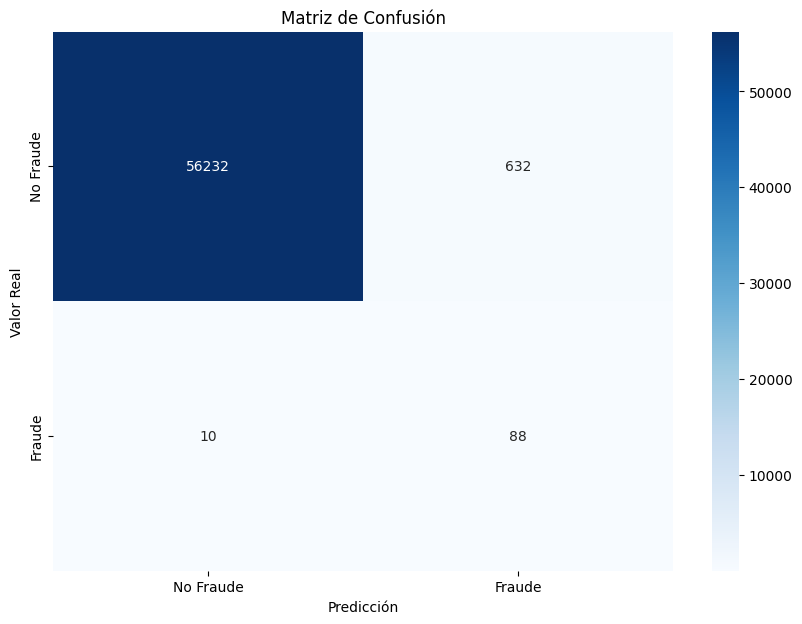

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Evaluación del Modelo ---
model.eval() # Ponemos el modelo en modo de evaluación
all_preds = []
all_labels = []
threshold = 0.5

with torch.no_grad(): # No necesitamos calcular gradientes durante la evaluación
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)

        # Convertir los logits de salida a probabilidades con sigmoide, para una mejor clasificación
        probs = torch.sigmoid(preds.squeeze())
        # Convertir probabilidades a predicciones binarias (0 o 1) con un umbral de 0.5
        preds = (probs >= threshold).float()

        all_preds.append(preds.cpu().numpy()) # con .cpu() traemos los datos desde la GPU
        all_labels.append(y.cpu().numpy())

# Unir todos los arrays de numpy
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# --- Cálculo y visualización de las métricas ---
print("\n--- Métricas de Evaluación ---")
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
# El informe de clasificación nos da precision, recall y F1-score de una vez.
print("\nInforme de Clasificación:")
print(classification_report(all_labels, all_preds, target_names=['No Fraude (0)', 'Fraude (1)']))

# --- Matriz de Confusión ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

Vemos que para la clase Fraude, tenemos aproximadamente un 0,07 de *precision* y un 0,91 de *recall*. ¿Es este un mal resultado? No necesariamente. Para este tipo de problemas, donde lo importante es detectar los fraudes, es un buen resultado. Indica que el modelo está teniendo muchos falsos positivos, pero eso es mejor que tener  falsos negativos. Lo puedes ver en la misma matriz de confusión, de las predicciones de Fraude, 1.196 ejemplos eran en realidad negativos, pero en el caso contrario (clasificados como negativo pero eran positivos) fueron solo 9. 

Este es conocido como el **problema del intercambio (trade-off)** entre precisión y recall. Es muy difícil aumentar una sin disminuir la otra. Por eso es importante entender bien el problema que estamos queriendo resolver:
* *Problemas donde detectar es crucial*: por ejemplo, detección de enfermedades, fraudes, etc. Lo mejor es fijarse en el recall.
* *Problemas donde demasiada detección es fatal*: por ejemplo, detección de humo en habitación, detección de armas en videovigilancia, etc (un detector que continuamente esté dando positivos lo convierte en [inútil](https://youtu.be/NITHLjbxJaE?si=34Y_UntcvYFdO9o4&t=29)). Lo mejor es fijarse en precision.
* En casos generales: Fijarse en el F1-score.



## 5. Trabajo opcional propuesto

* Prueba a entrenar el modelo sin la ponderación en la función de pérdida, ¿qué resultados obtienes?
* En los modelos anteriores hemos usado 2 capas ocultas... comprueba el efecto de ampliar o reducir este número sobre la accuracy de validación y de test.
* Cambia el número de unidades en las capas ocultas (8, 32, 64,...) y mide su efecto.
* Cambia la función de pérdida a `MSELoss`, en vez de `BCEWithLogitsLoss`, ¿qué ocurre en el entrenamiento?
* Modifica el modelo para que la última capa sea la función de activación `sigmoid`, y usa por tanto la función de pérdida `BCE`.
* Mira qué ocurre al usar la activación `Tanh` en vez de `ReLU` en las capas ocultas.

## 6. Conclusiones y recursos

A pesar de haber analizado únicamente un ejemplo de introducción sin llegar a profundizar en detalles ni experimentar profundamente con los parámetros, podemos ir ya apuntando algunas conclusiones importantes que pueden ayudarnos en casos posteriores:

* El trabajo de **preprocesamiento** sobre los datos es una etapa esencial para que puedas alimentar a las redes (no olvides que se alimentan de tensores).
* Es importante que las características sigan una *distribución parecida* entre ellas.
* Las pilas de capas lineales con activaciones `ReLU` pueden resolver una amplia variedad de problemas... así que no las olvides.
* En los problemas de clasificación binaria, la red debería acabar en una capa densa con una sola neurona que haga uso de la activación `sigmoid`. De esta forma, la salida será un único escalar en $[0,1]$ que se puede interpretar como una probabilidad. 
* En PyTorch, solemos optar por no usar la sigmoide y basarnos en los logits que obtenemos de la neurona de salida. En este caso la función de pérdida adecuada es `BCEWithLogitsLoss`.
* El optimizador `Adam` es normalmente una buena opción.
* Cuidado con el *overfitting*. Asegúrate de monitorear la evolución del entrenamiento (acuérdate de preparar un conjunto de validación adicional).
* En **datasets desbalanceados** debemos llevar precaución, porque el modelo puede sobreajustar a predicir siempre la clase predominante. Opciones a considerar cuando se trabaja con datasets desbalanceados:
  1. Conseguir más ejemplos de la clase minoritaria (es decir, más ejemplos de Fraude). Si no es posible:
  2. Aumentar los ejemplos de la clase minoritaria de forma artificial, a partir de los existentes (data augmentation). Si no es posible:
  3. Recortar la clase predominante para conseguir un mayor balance. Si se prefiere no hacerlo:
  4. Dar un peso mayor a la clase minoritaria en la función de pérdida (opción elegida en esta práctica).
* Es importante saber el tipo de problema que queremos resolver para fijarnos en unas métricas o en otras.

Recursos empleados:

* [Deep Learning with Python](https://deeplearningwithpython.io/chapters/), François Chollet, Matthew Watson
* [Credit card fraud detection with Pytorch](https://blacksuan19.dev/projects/credit-card-fraud-detection-with-pytorch/)
* [Cienciadedatos.net](https://cienciadedatos.net/documentos/py35-redes-neuronales-python.html)
* Gemini 2.5 Pro y GPT 5